# Quickstart guide

In this notebook we will through all the steps from downloading the data and training a model to evaluating the results. Check out the `environment.yml` file for the required Python packages.

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

## Downloading the data

The data is hosted here. For this guide we will simply download the a year (1997) data.

In [ ]:
# To do

## Open the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

data_dir = "/content/drive/MyDrive/regridded_zeta_step2"

# List all files in the directory
datasets = [f for f in os.listdir(data_dir) if f.endswith(".nc")]
datasets.sort()  # sort for readability

print("Available datasets:")
for ds in datasets:
    print(ds)

Available datasets:
NY_1998_180_360.nc
NY_1999_180_360.nc
NY_2000_180_360.nc
NY_2001_180_360.nc
NY_2002_180_360.nc
NY_2003_180_360.nc
NY_2004_180_360.nc
NY_2005_180_360.nc
NY_2006_180_360.nc
NY_2007_180_360.nc
NY_2008_180_360.nc
NY_2009_180_360.nc
NY_2010_180_360.nc
NY_2011_180_360.nc
NY_2012_180_360.nc
NY_2013_180_360.nc
NY_2014_180_360.nc
NY_2015_180_360.nc
NY_2016_180_360.nc
NY_2017_180_360.nc
NY_2018_180_360.nc
NY_2019_180_360.nc
NY_2020_180_360.nc
NY_2021_180_360.nc
NY_2022_180_360.nc
real_land_mask_180_360.nc


In [ ]:
mask = xr.open_dataset(f"{data_dir}/real_land_mask_180_360.nc")

In [ ]:
import os, glob
import xarray as xr
import pandas as pd
from datetime import timedelta

def _files_for_years(start_year: int, end_year: int):
    """Return existing file paths for years in [start_year, end_year]."""
    files = []
    years = []
    for y in range(start_year, end_year + 1):
        fn = os.path.join(data_dir, f"NY_{y}_180_360.nc")
        if os.path.exists(fn):
            files.append(fn)
            years.append(y)
        else:
            # silently skip missing years (e.g., 1997) but keep going
            pass
    if not files:
        raise FileNotFoundError(f"No yearly files found between {start_year} and {end_year}.")
    return files, years

def _safe_end_of_day(ts: pd.Timestamp) -> pd.Timestamp:
    """If user gave a date without time, extend to end-of-day (inclusive)."""
    if ts.time() == pd.Timestamp(0).time():  # 00:00:00
        # move to 23:59:59.999999999 for inclusive slice
        return ts + pd.Timedelta(days=1) - pd.Timedelta(nanoseconds=1)
    return ts

def parse_period(spec: str):
    """
    Accepts:
      - 'YYYY-YYYY'                (year range)
      - 'YYYYMMDD-YYYYMMDD'        (date range)
      - 'YYYYMMDDHH-YYYYMMDDHH'    (hourly datetimes)
    Returns (start_ts, end_ts).
    """
    spec = spec.strip()
    if "-" not in spec:
        raise ValueError("Period must be a range like '1998-2022' or '19980101-20101231'.")

    left, right = spec.split("-", 1)
    # Year-only range
    if len(left) == 4 and len(right) == 4:
        start = pd.to_datetime(f"{left}-01-01 00:00:00")
        # end of last year: inclusive
        end = pd.to_datetime(f"{right}-12-31 23:59:59")
        return start, end

    # Flexible datetime parsing for day or hour resolution
    # e.g., 19970101, 20101231, 1997010100, 2010123123
    def _parse_side(s):
        if len(s) == 8:    # YYYYMMDD
            return pd.to_datetime(s, format="%Y%m%d")
        elif len(s) == 10: # YYYYMMDDHH
            return pd.to_datetime(s, format="%Y%m%d%H")
        else:
            # Let pandas try, but it's better to be explicit above.
            return pd.to_datetime(s)

    start = _parse_side(left)
    end   = _parse_side(right)
    # Make end inclusive if no explicit time provided
    end = _safe_end_of_day(end)
    return start, end

def open_period(period_spec: str, chunks=None, parallel=False):
    """
    Open hourly data for the requested period, concatenated along time,
    then return the dataset sliced to the exact time window.
    - period_spec examples: '1998-2022', '19970101-20101231', '1998010100-1998123123'
    - chunks: dict for dask chunking, e.g. {'time': 24*30} (optional; requires dask)
    """
    start_ts, end_ts = parse_period(period_spec)
    start_year, end_year = start_ts.year, end_ts.year

    files, _ = _files_for_years(start_year, end_year)

    # Efficient multi-file open: rely on 'time' coords to align
    # If you have dask installed, pass e.g. chunks={'time': 24*30}
    ds = xr.open_mfdataset(
        files,
        combine="by_coords",
        parallel=parallel,
        chunks=chunks
    )

    # Clip to requested time range (inclusive)
    ds = ds.sel(time=slice(start_ts, end_ts))
    if ds.sizes.get("time", 0) == 0:
        raise ValueError(f"No data within requested window {start_ts} to {end_ts}.")
    return ds

In [ ]:
# --- Examples ---

# (A) Full-year span (matches what you asked):
# Note: your data starts at 1998; 1997 will be skipped automatically.
TIME_PERIOD = "1998-2022"

ds = open_period(TIME_PERIOD)

# (B) Date span:
# ds = open_period("19970101-20101231")

# (C) Hourly precision:
# ds = open_period("1998010100-1998123123")

# (D) With dask chunking (if dask installed) for better performance:
# ds = open_period("1998-2022", chunks={'time': 24*30}, parallel=True)

In [ ]:
print(ds)

<xarray.Dataset> Size: 114GB
Dimensions:    (time: 219144, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 2MB 1998-01-01 ... 2022-12-31T23:00:00
  * latitude   (latitude) float64 1kB 40.25 40.26 40.26 ... 41.49 41.49 41.5
  * longitude  (longitude) float64 3kB -74.5 -74.49 -74.48 ... -71.26 -71.25
Data variables:
    zeta       (time, latitude, longitude) float64 114GB dask.array<chunksize=(274, 6, 23), meta=np.ndarray>


In [ ]:
# Select: zeta
zeta = (ds["zeta"].sel(time=slice("1998-01-01T00:00:00", "2022-12-31T23:00:00")))

# Quick sanity checks
print(zeta)

<xarray.DataArray 'zeta' (time: 219144, latitude: 180, longitude: 360)> Size: 114GB
dask.array<concatenate, shape=(219144, 180, 360), dtype=float64, chunksize=(275, 6, 23), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2MB 1998-01-01 ... 2022-12-31T23:00:00
  * latitude   (latitude) float64 1kB 40.25 40.26 40.26 ... 41.49 41.49 41.5
  * longitude  (longitude) float64 3kB -74.5 -74.49 -74.48 ... -71.26 -71.25


In [ ]:
zeta_val = (ds["zeta"].sel(time=slice("2022-01-01T00:00:00", "2022-12-31T23:00:00")))
zeta_val

<xarray.DataArray 'zeta' (time: 8760, latitude: 180, longitude: 360)> Size: 5GB
dask.array<getitem, shape=(8760, 180, 360), dtype=float64, chunksize=(274, 6, 23), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31T23:00:00
  * latitude   (latitude) float64 1kB 40.25 40.26 40.26 ... 41.49 41.49 41.5
  * longitude  (longitude) float64 3kB -74.5 -74.49 -74.48 ... -71.26 -71.25

In [ ]:
str(zeta.time[0].values)[:19]
# '1998-01-01T00:00:00'

'1998-01-01T00:00:00'

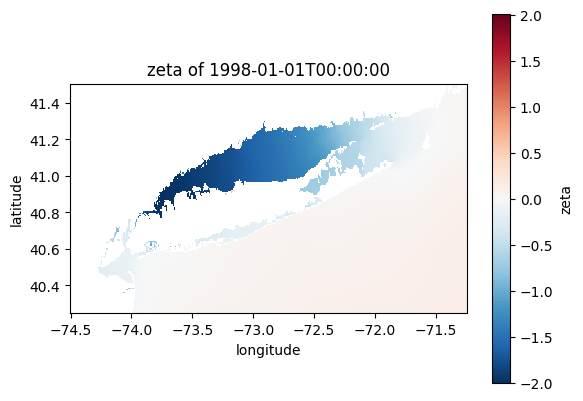

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
qm = zeta.isel(time=0).plot(ax=ax)
ax.set_aspect(1.5)
ax.set_title(f"zeta of {str(zeta.time[0].values)[:19]}")
plt.show()

## Create a simple Persistence forecast

In [ ]:
# persistence function from weatherbench (Too slow)

# def create_persistence_forecast(ds, lead_time_h):
#     assert lead_time_h > 0, 'Lead time must be greater than 0'
#     ds_fc = ds.isel(time=slice(0, -lead_time_h))
#     return ds_fc

# lead_times = xr.DataArray(
#     np.arange(1, 8753, 1), dims=['lead_time'], coords={'lead_time': np.arange(1, 8753, 1)}, name='lead_time')

# print(lead_times)

# persistence = []
# valid_data = zeta_val
# for l in lead_times:
#     persistence.append(create_persistence_forecast(valid_data, int(l)))
# persistence = xr.concat(persistence, dim=lead_times)

In [ ]:
import numpy as np
import xarray as xr

def persistence_forecast(valid_data: xr.DataArray, max_lead_h: int) -> xr.DataArray:
    """
    valid_data: DataArray with a 'time' dim (hourly)
    max_lead_h: maximum lead in hours (e.g., 8752)

    Returns: DataArray with dims ('lead_time', 'time', ...other dims...),
             where values are the persistence forecast initialized at 'time'
             for each lead_time. Includes a 2D 'valid_time' coord.
    """
    if max_lead_h <= 0:
        raise ValueError("Lead time must be greater than 0")

    # We’ll use the shortest common init-time range so that all leads have a verifying time.
    # If you prefer to keep full length and allow trailing NaNs, see the commented section below.
    init = valid_data.isel(time=slice(0, -max_lead_h))

    # Create lead_time coordinate
    lead_times = xr.DataArray(
        np.arange(1, max_lead_h + 1, dtype=int),
        dims=["lead_time"],
        name="lead_time"
    )

    # Broadcast the init values along lead_time without copying
    # (xarray will lazily broadcast; with dask, this stays lazy)
    fcst = init.expand_dims(lead_time=lead_times)

    # Attach a 2D valid_time coordinate so you can align to observations at t+lead
    # Assumes hourly spacing
    valid_time = xr.DataArray(
        init["time"].values[None, :] + lead_times.values[:, None].astype("timedelta64[h]"),
        dims=("lead_time", "time"),
        name="valid_time"
    )
    fcst = fcst.assign_coords(valid_time=valid_time)

    fcst.name = getattr(valid_data, "name", "persistence")
    return fcst

In [ ]:
max_lead = 1
persistence = persistence_forecast(zeta_val, max_lead)
persistence

<xarray.DataArray 'zeta' (lead_time: 1, time: 8759, latitude: 180,
                          longitude: 360)> Size: 5GB
dask.array<getitem, shape=(1, 8759, 180, 360), dtype=float64, chunksize=(1, 274, 6, 23), chunktype=numpy.ndarray>
Coordinates:
  * lead_time   (lead_time) int64 8B 1
  * time        (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31T22:00:00
  * latitude    (latitude) float64 1kB 40.25 40.26 40.26 ... 41.49 41.49 41.5
  * longitude   (longitude) float64 3kB -74.5 -74.49 -74.48 ... -71.26 -71.25
    valid_time  (lead_time, time) datetime64[ns] 70kB 2022-01-01T01:00:00 ......

### Evaluate the Persistence

In [ ]:
import numpy as np
import xarray as xr

def compute_weighted_rmse(forecast: xr.DataArray | xr.Dataset,
                          truth: xr.DataArray,
                          weights: xr.DataArray = None) -> xr.DataArray:
    """
    Compute weighted RMSE between forecast and truth.

    - If forecast has 'valid_time', truth is aligned to it.
    - If forecast has no time/valid_time (e.g. climatology), it is broadcast across truth.time.

    Parameters
    ----------
    forecast : xr.DataArray or xr.Dataset
        Forecast data. Can be:
          - (lead_time, time, lat, lon) with valid_time coordinate
          - (lat, lon) climatology field
    truth : xr.DataArray
        Observed data with 'time' and spatial dims.
    weights : xr.DataArray, optional
        Spatial weights (e.g. cos(lat)) with dims ('latitude',) or ('latitude','longitude').

    Returns
    -------
    rmse : xr.DataArray
        RMSE per lead_time if present, otherwise scalar RMSE.
    """

    # If forecast is a Dataset, pick the first variable (common for climatology)
    if isinstance(forecast, xr.Dataset):
        forecast = next(iter(forecast.data_vars.values()))

    if "valid_time" in forecast.coords:
        obs = truth.sel(time=forecast["valid_time"])
    elif "time" in forecast.dims:
        # Already aligned on time dimension
        obs = truth
    else:
        # Static climatology: broadcast to all truth times
        forecast = forecast.expand_dims(time=truth.time)
        obs = truth

    # Squared error
    sq_err = (forecast - obs) ** 2

    # Apply spatial weights
    if weights is not None:
        weights = weights / weights.sum()
        mse = sq_err.weighted(weights).mean(dim=("latitude", "longitude"))
    else:
        mse = sq_err.mean(dim=("latitude", "longitude"))

    # RMSE per forecast instance
    rmse_per_fc = np.sqrt(mse)

    # Average across forecast initializations if available
    if "time" in rmse_per_fc.dims:
        rmse = rmse_per_fc.mean(dim="time")
    else:
        rmse = rmse_per_fc

    rmse.name = "RMSE"
    return rmse

In [ ]:
# Uniform weighting
rmse = compute_weighted_rmse(persistence, zeta_val)
print(rmse.values)
# 0.20500668

[0.20500668]


## Create a simple Climatology forecast

In [ ]:
def create_climatology_forecast(ds_train):
    return ds_train.mean('time')

In [ ]:
train_data = ds.sel(time=slice(None, '2021'))
# print(train_data)

In [ ]:
climatology = create_climatology_forecast(train_data)

In [ ]:
print(climatology)

<xarray.Dataset> Size: 523kB
Dimensions:    (latitude: 180, longitude: 360)
Coordinates:
  * latitude   (latitude) float64 1kB 40.25 40.26 40.26 ... 41.49 41.49 41.5
  * longitude  (longitude) float64 3kB -74.5 -74.49 -74.48 ... -71.26 -71.25
Data variables:
    zeta       (latitude, longitude) float64 518kB dask.array<chunksize=(6, 23), meta=np.ndarray>


### Evaluate the Climatology

In [ ]:
rmse = compute_weighted_rmse(climatology, zeta_val)
print(rmse.values)

# 0.4254810360910775 (1h)

0.4254810360910775


## Train a neural network

Now let's train a simple convolutional neural network.

In [ ]:
import os
from pathlib import Path
from collections import OrderedDict
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

torch.__version__

# Set reproducibility seeds
torch.manual_seed(42)
np.random.seed(42)

# Priority order: CUDA > TPU > MPS > CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(42)
elif hasattr(torch, 'xla') or 'xla' in torch.__dict__:
    try:
        import torch_xla.core.xla_model as xm
        device = xm.xla_device()
    except ImportError:
        device = torch.device("cpu")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Using device:", device)


Using device: cuda


## PyTorch dataset


In [ ]:
# Configuration aligned with the quickstart dataset
DATA_DIR = Path(data_dir)
TARGET_VAR = "zeta"  # variable to forecast; e.g. 'geopotential'
# TIME_PERIOD = "1998-2000"  # inclusive range of years to load
TIME_STRIDE = max_lead  # keep every 6th hour to keep the demo lightweight


# Optional mask; set MASK_PATH to None to skip
MASK_PATH: Optional[Path] = DATA_DIR / "real_land_mask_180_360.nc"
# MASK_PATH = f"{data_dir}/real_land_mask_180_360.nc"
MASK_VARIABLE = "mask"  # variable name inside the mask file
MASK_THRESHOLD = 0.5  # when MASK_VALID_EQUALS is None, keep values >= threshold
MASK_VALID_EQUALS: Optional[float] = 0.0  # e.g. set to 0.0 if 0 marks valid land
MASK_EQUAL_TOL = 1e-6
MASK_INVERT = False  # flip valid/invalid if your mask marks land with low values

if not DATA_DIR.exists():
    raise FileNotFoundError(f"DATA_DIR {DATA_DIR} does not exist. Adjust the path before continuing.")


def _files_for_years(start_year: int, end_year: int):
    files = []
    for year in range(start_year, end_year + 1):
        candidate = DATA_DIR / f"NY_{year}_180_360.nc"
        if candidate.exists():
            files.append(candidate)
    if not files:
        raise FileNotFoundError(f"No yearly files found between {start_year} and {end_year} in {DATA_DIR}.")
    return files


def _safe_end_of_day(ts: pd.Timestamp) -> pd.Timestamp:
    if ts.time() == pd.Timestamp(0).time():
        return ts + pd.Timedelta(days=1) - pd.Timedelta(nanoseconds=1)
    return ts


def parse_period(spec: str):
    spec = spec.strip()
    if "-" not in spec:
        raise ValueError("Period must look like '1998-2002' or '19980101-19991231'.")
    left, right = spec.split("-", 1)
    if len(left) == 4 and len(right) == 4:
        start = pd.to_datetime(f"{left}-01-01 00:00:00")
        end = pd.to_datetime(f"{right}-12-31 23:59:59")
        return start, end

    def _parse_side(side: str) -> pd.Timestamp:
        if len(side) == 8:
            return pd.to_datetime(side, format="%Y%m%d")
        if len(side) == 10:
            return pd.to_datetime(side, format="%Y%m%d%H")
        return pd.to_datetime(side)

    start = _parse_side(left)
    end = _parse_side(right)
    end = _safe_end_of_day(end)
    return start, end


def open_period(period_spec: str, chunks=None, parallel=False) -> xr.Dataset:
    start_ts, end_ts = parse_period(period_spec)
    files = _files_for_years(start_ts.year, end_ts.year)
    ds = xr.open_mfdataset(
        [str(f) for f in files],
        combine="by_coords",
        parallel=parallel,
        chunks=chunks,
    )
    ds = ds.sel(time=slice(start_ts, end_ts))
    if ds.sizes.get("time", 0) == 0:
        raise ValueError(f"No data within requested window {start_ts} to {end_ts}.")
    return ds


def ensure_lat_lon_dims(ds: xr.Dataset) -> xr.Dataset:
    rename = {}
    if "latitude" in ds.dims and "lat" not in ds.dims:
        rename["latitude"] = "lat"
    if "longitude" in ds.dims and "lon" not in ds.dims:
        rename["longitude"] = "lon"
    return ds.rename(rename) if rename else ds


def subset_by_years(ds: xr.Dataset, years: np.ndarray) -> xr.Dataset:
    years = np.asarray(years, dtype=int)
    mask = ds["time"].dt.year.isin(years)
    return ds.sel(time=mask)


def rename_for_score(da: xr.DataArray) -> xr.DataArray:
    rename = {}
    if "lat" in da.dims and "latitude" not in da.dims:
        rename["lat"] = "latitude"
    if "lon" in da.dims and "longitude" not in da.dims:
        rename["lon"] = "longitude"
    return da.rename(rename) if rename else da


def load_land_mask() -> Optional[xr.DataArray]:
    if MASK_PATH is None or not MASK_PATH.exists():
        return None
    mask_ds = xr.open_dataset(MASK_PATH)
    if MASK_VARIABLE not in mask_ds:
        raise KeyError(f"{MASK_VARIABLE!r} not found in {MASK_PATH}")
    mask = ensure_lat_lon_dims(mask_ds[MASK_VARIABLE])
    return mask


In [ ]:
# # Derive simple train/validation/test splits from the available years.
# available_years = np.unique(ds.time.dt.year.values)
# if available_years.size < 3:
#     raise ValueError(
#         "TIME_PERIOD must span at least three distinct years to create train/valid/test splits."
#     )

# train_years = available_years[:-2]
# valid_years = available_years[-2:-1]
# test_years = available_years[-1:]

# if train_years.size == 0:
#     raise ValueError("Extend TIME_PERIOD so that at least one year is available for training.")

# # select data subsets

# ds_train = subset_by_years(ds, train_years)
# ds_valid = subset_by_years(ds, valid_years)
# ds_test = subset_by_years(ds, test_years)

# print(f"Train years: {train_years.tolist()}")
# print(f"Valid years: {valid_years.tolist()}")
# print(f"Test years:  {test_years.tolist()}")
# print(ds_train[TARGET_VAR])
# print(ds_valid[TARGET_VAR])
# print(ds_test[TARGET_VAR])


Train years: [1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Valid years: [2021]
Test years:  [2022]
<xarray.DataArray 'zeta' (time: 201624, latitude: 180, longitude: 360)> Size: 105GB
dask.array<getitem, shape=(201624, 180, 360), dtype=float64, chunksize=(273, 6, 23), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2MB 1998-01-01 ... 2020-12-31T23:00:00
  * latitude   (latitude) float64 1kB 40.25 40.26 40.26 ... 41.49 41.49 41.5
  * longitude  (longitude) float64 3kB -74.5 -74.49 -74.48 ... -71.26 -71.25
<xarray.DataArray 'zeta' (time: 8760, latitude: 180, longitude: 360)> Size: 5GB
dask.array<getitem, shape=(8760, 180, 360), dtype=float64, chunksize=(297, 6, 23), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 70kB 2021-01-01 ... 2021-12-31T23:00:00
  * latitude   (latitude) float64 1kB 40.25 40.26 40.26 ... 41.49 41.49 41.5
  * longitude  (

First, we need to create the data generators for training, validation and testing. The main reason why we are using data generators instead of just loading the data as Numpy arrays is that this would require loading the same data twice since the features and targets are the same fields, just offset in time.

In [ ]:
# Open the requested period, keep only the target variable, and optionally thin the time dimension.
ds_raw = open_period(TIME_PERIOD)
ds_raw = ensure_lat_lon_dims(ds_raw)

if TARGET_VAR not in ds_raw:
    raise KeyError(f"{TARGET_VAR!r} not found in dataset variables: {list(ds_raw.data_vars)}")

ds_raw = ds_raw[[TARGET_VAR]]

land_mask = load_land_mask()
if land_mask is not None:
    land_mask = land_mask.interp_like(ds_raw[TARGET_VAR], method="nearest")
    if MASK_VALID_EQUALS is not None:
        valid = np.isclose(land_mask, MASK_VALID_EQUALS, atol=MASK_EQUAL_TOL)
    else:
        valid = land_mask >= MASK_THRESHOLD
    if MASK_INVERT:
        valid = ~valid
    ds_raw[TARGET_VAR] = ds_raw[TARGET_VAR].where(valid)

if TIME_STRIDE and TIME_STRIDE > 1:
    ds_raw = ds_raw.isel(time=slice(0, None, TIME_STRIDE))

ds_raw


<xarray.Dataset> Size: 114GB
Dimensions:  (time: 219144, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 2MB 1998-01-01 ... 2022-12-31T23:00:00
  * lat      (lat) float64 1kB 40.25 40.26 40.26 40.27 ... 41.49 41.49 41.5
  * lon      (lon) float64 3kB -74.5 -74.49 -74.48 ... -71.27 -71.26 -71.25
Data variables:
    zeta     (time, lat, lon) float64 114GB dask.array<chunksize=(274, 6, 23), meta=np.ndarray>

In [ ]:
# Derive simple train/validation/test splits from the available years.
available_years = np.unique(ds_raw.time.dt.year.values)
if available_years.size < 3:
    raise ValueError(
        "TIME_PERIOD must span at least three distinct years to create train/valid/test splits."
    )

train_years = available_years[:-2]
valid_years = available_years[-2:-1]
test_years = available_years[-1:]

if train_years.size == 0:
    raise ValueError("Extend TIME_PERIOD so that at least one year is available for training.")

# select data subsets

ds_train = subset_by_years(ds_raw, train_years)
ds_valid = subset_by_years(ds_raw, valid_years)
ds_test = subset_by_years(ds_raw, test_years)

print(f"Train years: {train_years.tolist()}")
print(f"Valid years: {valid_years.tolist()}")
print(f"Test years:  {test_years.tolist()}")
print(ds_train[TARGET_VAR])
print(ds_valid[TARGET_VAR])
print(ds_test[TARGET_VAR])


Train years: [1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Valid years: [2021]
Test years:  [2022]
<xarray.DataArray 'zeta' (time: 201624, lat: 180, lon: 360)> Size: 105GB
dask.array<getitem, shape=(201624, 180, 360), dtype=float64, chunksize=(273, 6, 23), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2MB 1998-01-01 ... 2020-12-31T23:00:00
  * lat      (lat) float64 1kB 40.25 40.26 40.26 40.27 ... 41.49 41.49 41.5
  * lon      (lon) float64 3kB -74.5 -74.49 -74.48 ... -71.27 -71.26 -71.25
<xarray.DataArray 'zeta' (time: 8760, lat: 180, lon: 360)> Size: 5GB
dask.array<getitem, shape=(8760, 180, 360), dtype=float64, chunksize=(297, 6, 23), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 70kB 2021-01-01 ... 2021-12-31T23:00:00
  * lat      (lat) float64 1kB 40.25 40.26 40.26 40.27 ... 41.49 41.49 41.5
  * lon      (lon) float64 3kB -74.5 -74.49 -

In [ ]:
print(f"Train samples: {ds_train.sizes['time']}")
print(f"Valid samples: {ds_valid.sizes['time']}")
print(f"Test samples: {ds_test.sizes['time']}")


Train samples: 201624
Valid samples: 8760
Test samples: 8760


In [ ]:
import numpy as np
import xarray as xr
import torch
from torch.utils.data import Dataset
from collections import OrderedDict

def _get_lat_lon_names(ds):
    for lat_name in ("lat", "latitude", "y"):
        if lat_name in ds.dims:
            break
    else:
        raise ValueError("Latitude dim not found. Tried: lat, latitude, y")
    for lon_name in ("lon", "longitude", "x"):
        if lon_name in ds.dims:
            break
    else:
        raise ValueError("Longitude dim not found. Tried: lon, longitude, x")
    return lat_name, lon_name

def _stack_vars_levels(ds, var_dict, lat_name, lon_name):
    """Return DataArray of shape (time, lat, lon, level_concat) and bookkeeping dicts."""
    generic_level = xr.DataArray([1], dims=["level"], coords={"level": [1]})
    data_arrays = []
    level_slices = OrderedDict()
    level_coords = {}
    offset = 0
    for var, levels in OrderedDict(var_dict).items():
        da = ds[var]
        if "level" in da.dims:  # 3D var
            da_sel = da if levels is None else da.sel(level=levels)
        else:  # 2D var → add a mock level dim
            if levels is not None:
                raise ValueError(f"{var} does not have 'level' dim")
            da_sel = da.expand_dims(level=[1])
        # Enforce dim order (time, lat, lon, level)
        da_sel = da_sel.transpose("time", lat_name, lon_name, "level")
        data_arrays.append(da_sel)

        nlev = da_sel.sizes["level"]
        level_slices[var] = slice(offset, offset + nlev)
        level_coords[var] = None if levels is None else np.array(da_sel.level.values)
        offset += nlev

    data = xr.concat(data_arrays, dim="level")  # (time, lat, lon, level_concat)
    return data, level_slices, level_coords

def _compute_stats(data, lat_name, lon_name, mask=None, weights=None):
    """
    Compute mean/std per channel (level) over (time, lat, lon) consistently.
    If mask (1=land,0=ocean) is provided, exclude land. If weights provided,
    use xarray.weighted for area weighting (e.g., cos(lat) * ocean_mask).
    """
    if mask is not None:
        # Keep ocean only (mask==0)
        data = data.where(mask == 0)

    reduce_dims = ("time", lat_name, lon_name)

    if weights is not None:
        # If a 1D lat weight is passed, broadcast it
        if weights.dims == (lat_name,):
            weights = weights.broadcast_like(data.isel(time=0, level=0))
        # Zero out land if mask present
        if mask is not None:
            weights = weights.where(mask == 0, 0)

        wmean = data.weighted(weights).mean(reduce_dims, skipna=True)
        # Var = E[x^2] - (E[x])^2 with weights to avoid multiple passes
        wmean_sq = (data**2).weighted(weights).mean(reduce_dims, skipna=True)
        wvar = (wmean_sq - wmean**2).clip(min=0.0)
        wstd = np.sqrt(wvar)
        mean, std = wmean, wstd
    else:
        mean = data.mean(reduce_dims, skipna=True)
        std = data.std(reduce_dims, skipna=True)

    # Sanitize NaNs/zeros
    mean = mean.fillna(0.0).astype("float32")
    std = std.fillna(1.0).astype("float32")
    std = xr.where(std == 0, 1.0, std)
    return mean, std

class CoraDataset(Dataset):
    """PyTorch Dataset for NeuralCORA-style gridded data with optional masking/weights."""
    def __init__(
        self,
        ds,
        var_dict,
        lead_time,
        mean=None,
        std=None,
        load_into_memory=True,
        mask: xr.DataArray | None = None,   # 1=land, 0=ocean
        weights: xr.DataArray | None = None # e.g., cos(lat)*ocean_mask for stats
    ):
        self.ds = ds
        self.var_dict = OrderedDict(var_dict)
        self.lead_time = int(lead_time)

        lat_name, lon_name = _get_lat_lon_names(ds)
        self.lat_name, self.lon_name = lat_name, lon_name

        data, level_slices, level_coords = _stack_vars_levels(ds, self.var_dict, lat_name, lon_name)
        self.level_slices = level_slices
        self.level_coords = level_coords

        # Optional: apply land mask to data values (keep ocean, drop land)
        if mask is not None:
            data = data.where(mask == 0)

        # Compute or accept stats (per channel)
        if mean is None or std is None:
            mean_c, std_c = _compute_stats(data, lat_name, lon_name, mask=mask, weights=weights)
            self.mean = mean_c if mean is None else mean
            self.std  = std_c  if std  is None else std
        else:
            self.mean, self.std = mean, std

        # Normalize
        data = (data - self.mean) / self.std

        if load_into_memory:
            data = data.load()  # materialize now

        # (time, lat, lon, level) → (time, level, lat, lon) for PyTorch
        arr = np.moveaxis(data.values.astype("float32"), -1, 1)
        arr = np.nan_to_num(arr, nan=0.0, posinf=0.0, neginf=0.0)

        self.n_samples = arr.shape[0] - self.lead_time
        if self.n_samples <= 0:
            raise ValueError("Lead time too large for available samples.")

        self.inputs  = arr[:self.n_samples]                              # (N, C, H, W)
        self.targets = arr[self.lead_time:self.lead_time + self.n_samples]# (N, C, H, W)
        self.full_array = arr
        self.channels = arr.shape[1]

        # Keep coords
        self.init_time  = data.isel(time=slice(None, -self.lead_time)).time.values
        self.valid_time = data.isel(time=slice(self.lead_time, None)).time.values
        self.lat = data[self.lat_name].values
        self.lon = data[self.lon_name].values

        # For unnormalize
        mean_vals = np.nan_to_num(self.mean.values.astype("float32"), nan=0.0)
        std_vals  = np.nan_to_num(self.std.values.astype("float32"),  nan=1.0)
        std_vals  = np.where(std_vals == 0.0, 1.0, std_vals)
        self.mean_np = mean_vals[None, :, None, None]
        self.std_np  = std_vals [None, :, None, None]

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        # Tensors already channels-first
        x = torch.from_numpy(self.inputs[idx])
        y = torch.from_numpy(self.targets[idx])
        return x, y

    def unnormalize(self, values):
        return values * self.std_np + self.mean_np

    def to_xarray(self, values, times):
        values = np.asarray(values)  # (time, C, H, W)
        datasets = []
        for var, slc in self.level_slices.items():
            field = values[:, slc, :, :]  # (time, nlev, H, W)
            if self.var_dict[var] is None:  # single level
                datasets.append(xr.DataArray(
                    field[:, 0],
                    dims=("time", self.lat_name, self.lon_name),
                    coords={"time": times, self.lat_name: self.lat, self.lon_name: self.lon},
                    name=var
                ))
            else:
                level_coords = self.level_coords.get(var)
                if level_coords is None:
                    level_coords = np.arange(field.shape[1])
                datasets.append(xr.DataArray(
                    np.moveaxis(field, 1, -1),  # (time, H, W, nlev)
                    dims=("time", self.lat_name, self.lon_name, "level"),
                    coords={"time": times, self.lat_name: self.lat, self.lon_name: self.lon, "level": level_coords},
                    name=var
                ))
        return xr.merge(datasets)

In [ ]:
var_dict = OrderedDict({TARGET_VAR: None})
batch_size = 8
lead_time = max_lead  # number of index steps ahead (4 * TIME_STRIDE hours)

In [ ]:
#  Flattens multiple variables (and optional pressure levels) into a single channels axis.
#  Normalizes with train stats.
#  Produces pairs of (x[t], y[t+lead]) in channels-first tensors for PyTorch.
#  Exposes init_time, valid_time, etc.

train_ds = CoraDataset(ds_train, var_dict, lead_time, load_into_memory=True)
valid_ds = CoraDataset(ds_valid, var_dict, lead_time, mean=train_ds.mean, std=train_ds.std, load_into_memory=True)
test_ds = CoraDataset(ds_test, var_dict, lead_time, mean=train_ds.mean, std=train_ds.std, load_into_memory=True)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


In [ ]:
print(train_ds.mean.values, train_ds.std.values)

### 1. Create and train CNN model

In [ ]:
class PeriodicConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dropout=0.0):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, padding_mode='circular')
        self.activation = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        x = self.dropout(x)
        return x


class NeuralCoraCNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, kernel_size, out_channels, dropout=0.0):
        super().__init__()
        layers = []
        current = in_channels
        for out_channels_hidden in hidden_channels:
            layers.append(PeriodicConvBlock(current, out_channels_hidden, kernel_size, dropout))
            current = out_channels_hidden
        self.backbone = nn.Sequential(*layers)
        self.head = nn.Conv2d(current, out_channels, kernel_size, padding=kernel_size // 2, padding_mode='circular')

    def forward(self, x):
        features = self.backbone(x)
        return self.head(features)


In [ ]:
hidden_channels = [64, 64, 64, 64]
kernel_size = 3
model = NeuralCoraCNN(train_ds.channels, hidden_channels, kernel_size, out_channels=train_ds.channels).to(device)
model

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
def fit(model, train_loader, valid_loader, optimizer, criterion, epochs, device):
    history = {'train': [], 'valid': []}
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)
        history['train'].append(train_loss)

        val_loss = float('nan')
        if valid_loader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for xb, yb in valid_loader:
                    xb = xb.to(device)
                    yb = yb.to(device)
                    preds = model(xb)
                    loss = criterion(preds, yb)
                    val_loss += loss.item() * xb.size(0)
            val_loss /= len(valid_loader.dataset)
        history['valid'].append(val_loss)
        print(f'Epoch {epoch + 1}/{epochs}: train {train_loss:.4f} val {val_loss:.4f}')
    return history


In [ ]:
num_epochs = 3
history = fit(model, train_loader, valid_loader, optimizer, criterion, num_epochs, device)

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(history['train'], label='train')
if not np.isnan(history['valid']).all():
    plt.plot(history['valid'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.legend()
plt.tight_layout()
plt.show()

#### Create a prediction and compute score

Now that we have a model (albeit a crappy one) we can create a prediction. For this we need to create a forecast for each forecast initialization time in the testing range (2017-2018) and unnormalize it. We then convert the forecasts to a Xarray dataset which allows us to easily compute the RMSE. All of this is taken care of in the `create_predictions()` function.

In [ ]:
def create_predictions(model, loader, dataset, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(device)
            outputs = model(xb).cpu().numpy()
            preds.append(outputs)
    preds = np.concatenate(preds, axis=0)
    preds = dataset.unnormalize(preds)
    return dataset.to_xarray(preds, dataset.valid_time)


In [ ]:
cnn_preds = create_predictions(model, test_loader, test_ds, device)

In [ ]:
import numpy as np
import xarray as xr

def compute_weighted_rmse(forecast: xr.DataArray | xr.Dataset,
                          truth: xr.DataArray,
                          weights: xr.DataArray | None = None) -> xr.DataArray:
    if isinstance(forecast, xr.Dataset):
        forecast = next(iter(forecast.data_vars.values()))

    if "valid_time" in forecast.coords:
        obs = truth.sel(time=forecast["valid_time"])
    elif "time" in forecast.dims:
        obs = truth
    else:
        forecast = forecast.expand_dims(time=truth.time)
        obs = truth

    sq_err = (forecast - obs) ** 2

    if weights is not None:
        norm_weights = weights / weights.sum()
        mse = sq_err.weighted(norm_weights).mean(dim=("latitude", "longitude"))
    else:
        spatial_dims = [dim for dim in sq_err.dims if dim not in {"time", "lead_time"}]
        mse = sq_err.mean(dim=spatial_dims)

    rmse_per_fc = np.sqrt(mse)

    if "time" in rmse_per_fc.dims:
        rmse = rmse_per_fc.mean(dim="time")
    else:
        rmse = rmse_per_fc

    rmse.name = "RMSE"
    return rmse


In [ ]:
truth = rename_for_score(test_ds.ds[TARGET_VAR].sel(time=test_ds.valid_time))
preds_da = rename_for_score(cnn_preds[TARGET_VAR])

# lat_weights = np.cos(np.deg2rad(truth.latitude))
rmse = compute_weighted_rmse(preds_da, truth, weights=None)
print(rmse.values)

0.20375785854097686


### 2. Create and train Resnet model

In [ ]:
# To do Before Oct 8



### 3. Create and train Unet model

In [ ]:
# To do Before Oct 8

### 4. Create and train VIT model

In [ ]:
# To do

# The End

This is the end of the quickstart guide. Please refer to the Jupyter notebooks in the `notebooks` directory for more examples. If you have questions, feel free to ask them as a Github Issue.